# Exercise: Simple outlier removal on meteorological data
## Instructions
1. Load the data from the csv file
2. We are going to look at data retrived from "sensor 2", which measures temperature, humidity and pressure (columns `Temp2`, `Pression` and `hum2`). Create a new dataframe containing only these columns.
3. Use `plotly.express` to plot the points in each column. Use `px.scatter` to see only the available points without connecting lines. Zoom around and notice how the time frequency of the measuremnts is variable. Note many dates have no measurements registered. Do you see hints of outlier presence? 
4. Plot histograms and use the `describe` function to visualize some statistics. Do you see hints of outlier presence?
5. Plot each column using boxplots (using `pandas.DataFrame.plot(kind='box',...)`). Do you see any outliers in the plots?
6. Try changing the whiskers limits using the parameter `whis`, and observe the difference in the number of outliers detected. Repeat the plot for the following thresholds:
    - +- 3 IQR
    - bottom 5% / top 95%
    - bottom 1% / top 99%
    - bottom 0.5% / top 99.5%
7. Based on the previous thresholds, use a simple method to remove some of the outliers. 
    - Select apropriate tresholds for each column
    - You can just remove them (with a mask) or use winsorizing (`pd.clip`). 
    - Save the clean data to a **new** dataframe, **do not overwrite the previous one**.
8. To exemplify the effect of removing outliers, you are going to plot a heatmat representing the correlation matrix of these columns. 
    - Repeat the plot for the data with and without outliers. 
    - Did you observe major changes in the correlation indexes? 
    - You can use the following code to plot the correlation heatmap:
        ``` python
        sns.heatmap(data.corr(),
                    vmin=-1, vmax=1,
                    annot=True, fmt=".2f", cmap='coolwarm',
                    mask=np.tri(data.shape[1], k=-1).T)
        ```



## Useful documentation
- [Plotly express `scatter`](https://plotly.com/python-api-reference/generated/plotly.express.scatter.html)
- [Pandas `DataFrame.plot(kind=...)`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)
- [Matplotlib `hist`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist.html)
- [Seaborn `histplot`](https://seaborn.pydata.org/generated/seaborn.histplot.html)
- [Matplotlib `boxplot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.boxplot.html)
- [Seaborn `boxplot`](https://seaborn.pydata.org/generated/seaborn.boxplot.html)
- [Pandas `DataFrame.clip`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html)

# Imports

In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

import plotly.express as px
#increase font size of all elements
sns.set(font_scale=1.5)


# Load the data

In [64]:
import urllib.request

url = 'https://raw.githubusercontent.com/EPF-MDE/data-cleaning/main/Outliers/data/donnee_Station_Meteo.csv'
filename = 'meteo_data.csv'

# Download the file and save it to the local disk
urllib.request.urlretrieve(url, filename)

# Load the file into a Pandas DataFrame
full_data = pd.read_csv(filename, sep=';',index_col=1,parse_dates=[1])
display(full_data.info())
display(full_data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3036 entries, 2018-06-22 12:00:52 to 2022-01-31 07:08:40
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             3036 non-null   int64  
 1   Temp1          3036 non-null   float64
 2   hum1           3036 non-null   float64
 3   Pression       3036 non-null   float64
 4   Temp2          3036 non-null   float64
 5   hum2           3036 non-null   float64
 6   Conc_Stand_1   3036 non-null   int64  
 7   Conc_Stand_25  3036 non-null   int64  
 8   Conc_Stand_10  3036 non-null   int64  
 9   Conc_Env_1     3036 non-null   int64  
 10  Conc_Env_25    3036 non-null   int64  
 11  Conc_Env_10    3036 non-null   int64  
 12  Part_03        3036 non-null   int64  
 13  Part_05        3036 non-null   int64  
 14  Part_1         3036 non-null   int64  
 15  Part_25        3036 non-null   int64  
 16  Part_5         3036 non-null   int64  
 17  Part_50        3

None

,id,Temp1,hum1,Pression,Temp2,hum2,Conc_Stand_1,Conc_Stand_25,Conc_Stand_10,Conc_Env_1,Conc_Env_25,Conc_Env_10,Part_03,Part_05,Part_1,Part_25,Part_5,Part_50,Lum,
time,,,,,,,,,,,,,,,,,,,,
2018-06-22 12:00:52,1,28.70,41.45,1011.88,29.07,50.52,6,10,22,6,10,22,0,0,0,0,0,0,51,
2018-06-22 12:05:59,2,26.67,44.21,1011.90,26.63,53.92,6,9,9,6,9,9,1164,366,50,3,0,0,54,
2018-06-22 12:11:05,3,25.63,46.44,1011.81,26.34,54.95,6,8,10,6,8,10,1164,340,37,5,2,0,22,
2018-06-22 12:16:12,4,24.88,50.00,1011.77,26.07,57.26,7,8,9,7,8,9,1245,367,45,3,1,0,9,
2018-06-22 12:21:19,5,24.95,49.12,1011.67,26.01,56.83,4,6,6,4,6,6,1182,332,28,2,0,0,11,


# Select columns of interest

In [65]:
data_interest = full_data[['Temp2', 'Pression', 'hum2']].copy()
data_interest

,Temp2,Pression,hum2
time,,,
2018-06-22 12:00:52,29.07,1011.88,50.52
2018-06-22 12:05:59,26.63,1011.90,53.92
2018-06-22 12:11:05,26.34,1011.81,54.95
2018-06-22 12:16:12,26.07,1011.77,57.26
2018-06-22 12:21:19,26.01,1011.67,56.83
...,...,...,...
2022-01-23 15:23:36,12.63,1023.85,100.00
2022-01-23 15:24:06,12.60,1023.82,100.00
2022-01-24 14:45:46,15.50,1025.13,100.00


# Visualize data points

In [66]:
# Plot temperature
fig = px.scatter(data_interest, x=data_interest.index, y='Temp2', title='Temperature')
fig.show()

# Plot pressure
fig = px.scatter(data_interest, x=data_interest.index, y='Pression', title='Pressure')
fig.show()

# Plot humidity
fig = px.scatter(data_interest, x=data_interest.index, y='hum2', title='Humidity')
fig.show()


# Plot histograms


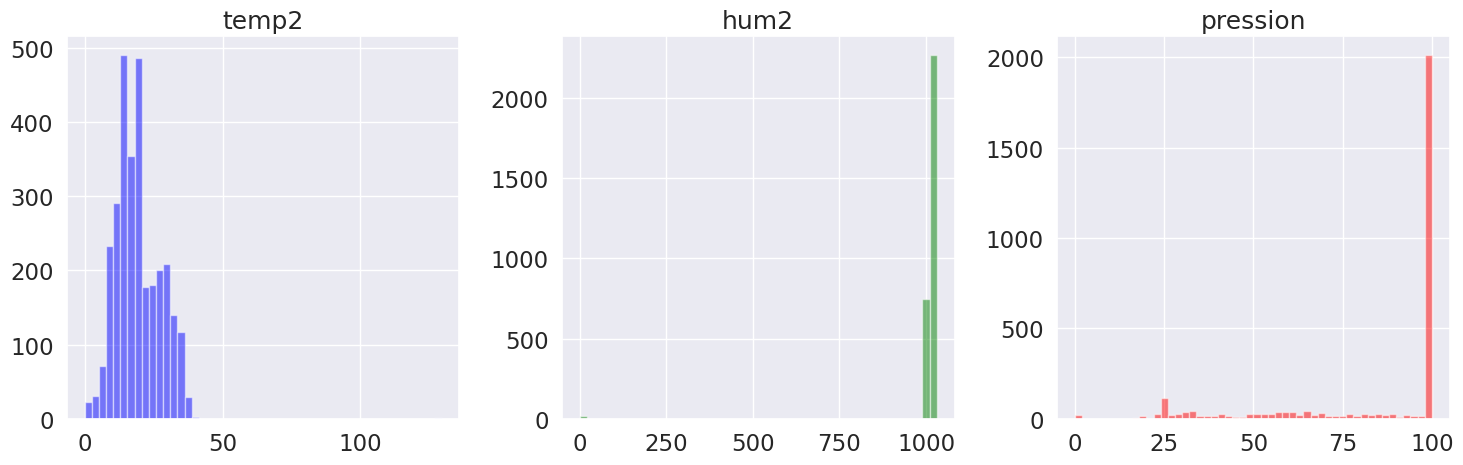

In [67]:
# plt.hist(data_interest['Temp2'], bins=50)
# plt.xlabel('Temperature')
# plt.ylabel('Frequency')
# plt.show()


# Create a figure and three subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot data on each subplot
axs[0].hist(data_interest['Temp2'], bins=50, color='blue', alpha=0.5)
axs[0].set_title('temp2')
axs[1].hist(data_interest['Pression'], bins=50, color='green', alpha=0.5)
axs[1].set_title('hum2')
axs[2].hist(data_interest['hum2'], bins=50, color='red', alpha=0.5)
axs[2].set_title('pression')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


# Print basic statistics wtih `describe`


In [68]:
print(data_interest.describe())

             Temp2     Pression         hum2
count  3036.000000  3036.000000  3036.000000
mean     19.160418  1006.951647    84.246815
std       8.106661    83.064496    26.049077
min       0.000000     0.000000     0.000000
25%      13.360000  1010.217500    69.987500
50%      18.270000  1013.135000   100.000000
75%      25.022500  1017.592500   100.000000
max     129.370000  1030.880000   100.000000


# Plot box-plots


### Cut-out at +- 1.5 IQR

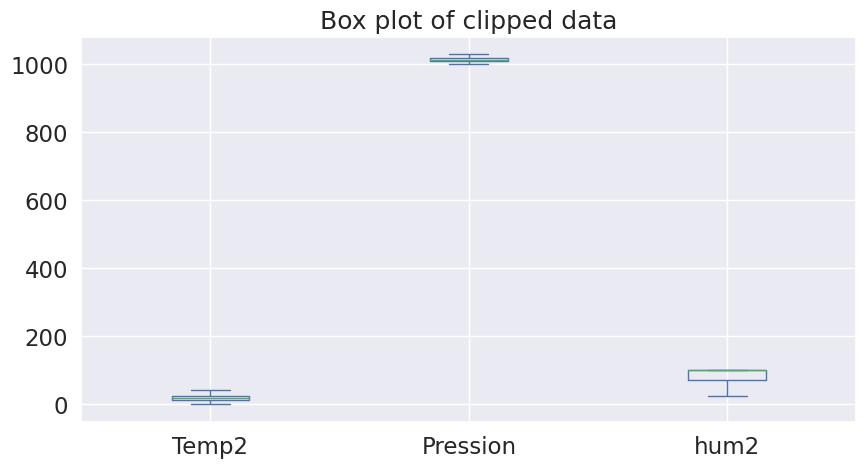

In [69]:
q1 = data_interest.quantile(0.25, interpolation='nearest')
q3 = data_interest.quantile(0.75, interpolation='nearest')
lower = q1 - 1.5 * IQR
upper = q3 + 1.5 * IQR
data_clipped = data_interest.clip(lower=lower, upper=upper, axis=1)
data_clipped.plot(kind='box', figsize=(10, 5))
plt.title('Box plot of clipped data')
plt.show()


### Cut-out at 5%/95%

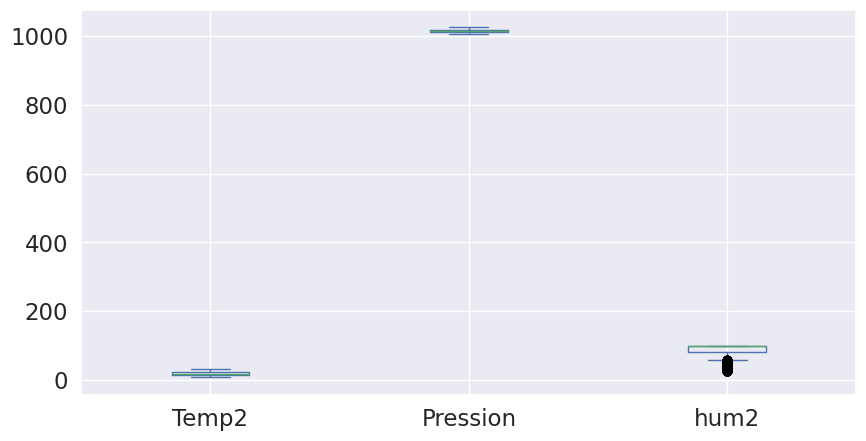

In [70]:
p5 = data_interest.quantile(0.05)
p95 = data_interest.quantile(0.95)

mask = (data_interest < p5) | (data_interest > p95)

data_filtered = data_interest.mask(mask)

data_filtered.plot(kind='box', figsize=(10, 5))
plt.show()


### Cut-out at 1%/99%

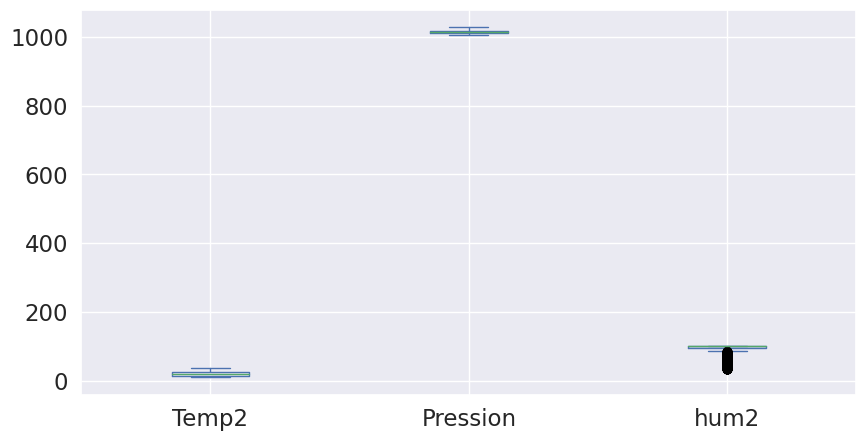

In [71]:
p5 = data_interest.quantile(0.1)
p95 = data_interest.quantile(0.99)

mask = (data_interest < p5) | (data_interest > p95)

data_filtered = data_interest.mask(mask)

data_filtered.plot(kind='box', figsize=(10, 5))
plt.show()


### Cut-out at 0.5%/99.5%

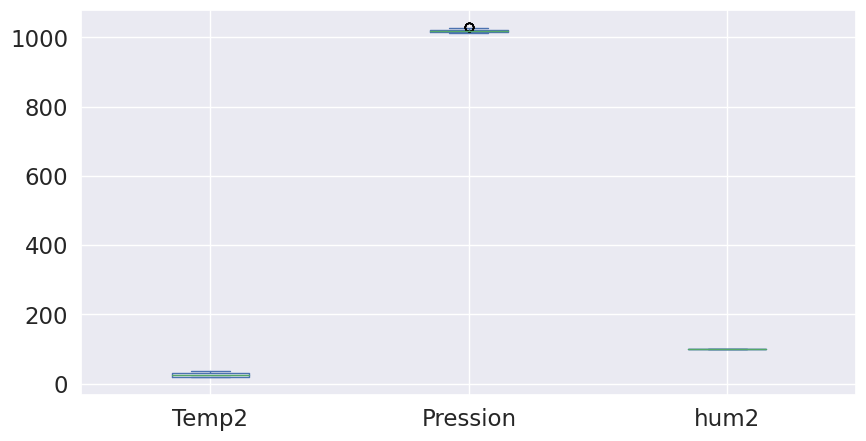

In [72]:
p5 = data_interest.quantile(0.5)
p95 = data_interest.quantile(0.995)

mask = (data_interest < p5) | (data_interest > p95)

data_filtered = data_interest.mask(mask)

data_filtered.plot(kind='box', figsize=(10, 5))
plt.show()


# Use a simple method to remove outliers

In [73]:
lower = data_interest.quantile(0.5)
upper = data_interest.quantile(0.995)

clean_data = data_interest.clip(lower=lower, upper=upper, axis=1)

mask = ((data_interest >= lower) & (data_interest <= upper)).all(axis=1)
clean_data = data_interest.loc[mask, :].copy()
clean_data


,Temp2,Pression,hum2
time,,,
2018-09-19 05:39:11,18.62,1016.53,100.0
2018-09-19 05:40:42,18.70,1016.50,100.0
2018-11-12 11:29:36,20.30,1017.08,100.0
2018-11-12 11:31:01,20.42,1017.10,100.0
2019-04-27 16:51:02,20.18,1018.03,100.0
...,...,...,...
2021-09-01 05:16:23,18.83,1014.59,100.0
2021-09-02 05:18:28,19.35,1014.67,100.0
2021-09-25 05:53:26,21.36,1013.16,100.0


# Plot column correlation with outliers

<Axes: >

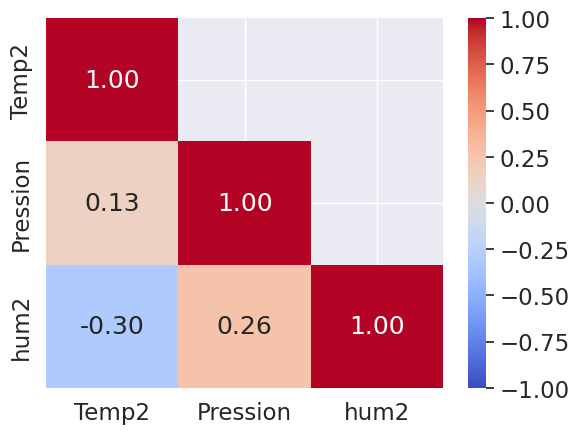

In [74]:
sns.heatmap(data_interest.corr(),vmin=-1, vmax=1,annot=True, fmt=".2f", cmap='coolwarm',mask=np.tri(data_interest.shape[1], k=-1).T)

# Plot column correlation after removing outliers

<Axes: >

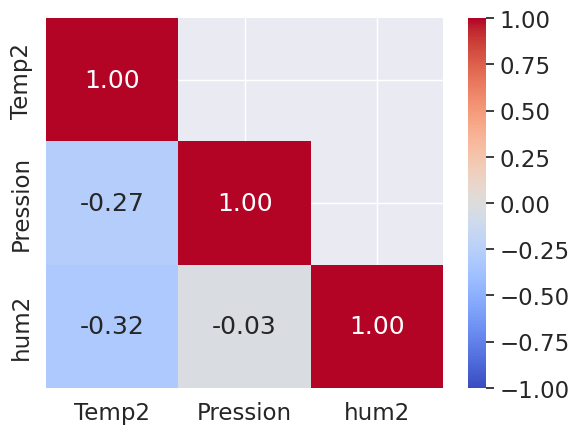

In [75]:
sns.heatmap(data_clipped.corr(),vmin=-1, vmax=1,annot=True, fmt=".2f", cmap='coolwarm',mask=np.tri(data_interest.shape[1], k=-1).T)